# Monet CycleGAN - Using GANs to create art 

## Problem Description

Artists are often recognized by their distinctive styles—through unique color palettes, brushwork, and composition. Emulating such artistic expression has long been considered the domain of human creativity, but recent advancements in computer vision and deep learning have made it possible to mimic these visual styles algorithmically. In particular, Generative Adversarial Networks (GANs) have emerged as powerful tools capable of generating images that closely resemble real-world objects—and even artistic masterpieces.

This challenge explores whether data science can convincingly replicate the nuanced style of Claude Monet. The task is to build a GAN that can generate thousands of images in the impressionist style of Monet, such that even a trained classifier may be "fooled" into believing the generated images are authentic. The GAN architecture consists of two competing neural networks: a generator, which learns to create Monet-style images, and a discriminator, which learns to distinguish real Monet paintings from generated ones. These networks train in opposition, improving each other through this adversarial process.

The specific goal is to train a GAN to produce between 7,000 to 10,000 Monet-style images that reflect the visual characteristics of Monet's artwork. Success will depend on how well your generator can capture the artist’s aesthetic, and how effectively your model can fool the discriminator into believing its creations are real.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2025-04-21 12:13:54.345077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745237634.590471      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745237634.661582      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of replicas: 1
2.18.0


## Load in the data

This code retrieves the Google Cloud Storage (GCS) path for a Kaggle dataset using KaggleDatasets().get_gcs_path() and then loads the file paths for Monet-style paintings and real photos stored in TFRecord format. It uses tf.io.gfile.glob() to find all files matching the specified patterns within the Monet and photo TFRecord directories, and prints the number of files found in each. This setup is typically used to prepare image data for training a model, such as a CycleGAN.

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [3]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

I0000 00:00:1745237650.467628      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745237650.468288      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


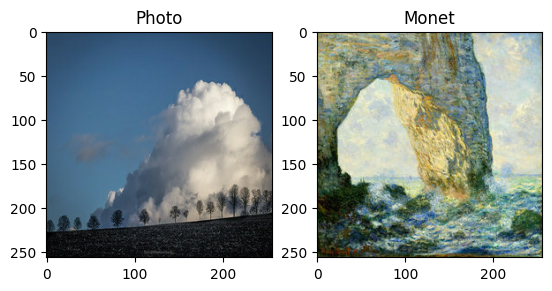

In [4]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Build the Generator

This is a U-Net generator that:

* Downsamples an input image to a latent representation (1×1),

* Then upsamples it back to full resolution,

* While using skip connections between encoder and decoder layers to preserve spatial detail.

In [5]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer="ones",
            trainable=True)
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        normalized = (x - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(InstanceNormalization())
        #result.add(layers.LayerNormalization(axis=[1, 2])())
        #result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(InstanceNormalization())
    #result.add(layers.LayerNormalization(axis=[1, 2])())
    #result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def residual_block(x, filters):
    init = x
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    return layers.Add()([init, x])

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Build the Descriminator

Define a PatchGAN-style discriminator, a popular architecture used in models like Pix2Pix.

* It classifies whether image patches are real or fake rather than the entire image.

* The final output is a 30×30 grid of real/fake scores, not a single scalar.

* This enables fine-grained discrimination, focusing on local image structure.


In [6]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = InstanceNormalization()(conv)
    #norm1 = layers.LayerNormalization(axis=[1, 2])(conv)
    #norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [7]:
with strategy.scope():
    
    monet_generator = Generator() 
    photo_generator = Generator() 

    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

Let's just try out the untrained generator

I0000 00:00:1745237653.451718      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


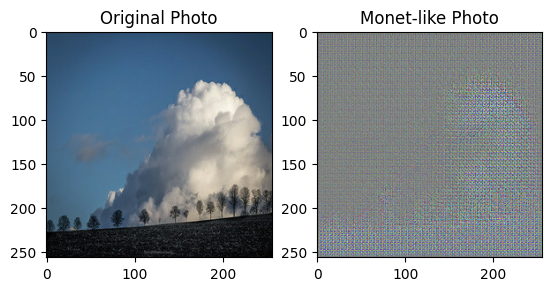

In [8]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-like Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

## Build a CycleGAN model

A CycleGAN is a generative adversarial network designed for unpaired image-to-image translation, such as converting real-world photos to Monet-style paintings and vice versa, without needing aligned image pairs. It consists of two generator networks and two discriminator networks. One generator, G, learns to transform photos into Monet paintings, while the other generator, F, learns to transform Monet paintings back into photos. The discriminators, Dy and Dx, evaluate the realism of the generated Monet paintings and photos, respectively.

During training, the model applies a transformation cycle to enforce consistency. For instance, a real photo x is transformed into a fake Monet painting using generator G, and then the result is passed through generator F to reconstruct the original photo. This reconstructed photo is compared to the original using a cycle-consistency loss, calculated as the L1 norm between x and F(G(x)). The same process occurs in reverse for Monet paintings, ensuring that a painting translated to a photo and back again remains close to the original.

In addition to adversarial loss, which encourages the generators to produce images indistinguishable from real examples, the cycle-consistency loss helps preserve the structure and content of the original image. An optional identity loss can also be used to encourage the model to maintain color and texture when translating images already in the target domain. Together, these components enable the CycleGAN to learn meaningful style transformations while retaining the essential characteristics of the original images.

In [9]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Define the Loss Functions

The discriminator loss measures how well the discriminator can distinguish real images from fake ones. It uses binary cross-entropy loss with logits, comparing the output of the discriminator for real images (which should be close to 1) and generated images (which should be close to 0). The real_loss penalizes the discriminator if it misclassifies real images as fake, while the generated_loss penalizes it for classifying fake images as real. These two components are summed and scaled by 0.5 to form the total discriminator loss, ensuring balanced contribution from both terms.

The generator loss evaluates how well the generator can fool the discriminator. It also uses binary cross-entropy with logits but compares the discriminator's output for generated images to a target of ones. This encourages the generator to produce images that the discriminator classifies as real. A lower generator loss means the generated images are more realistic in the eyes of the discriminator.

The cycle-consistency loss ensures that the core content and structure of an image are preserved through the forward and backward transformations. It computes the mean absolute error (L1 loss) between a real image and the version that was transformed to the other domain and then back again. This loss penalizes large differences between the original and reconstructed images and is scaled by a hyperparameter LAMBDA to balance it with adversarial losses.

Finally, the identity loss is used to regularize the generators by encouraging them to produce outputs that closely match the input when the input is already in the target domain. This helps maintain color, texture, and other low-level details. It is computed as the mean absolute difference between the real image and the same image processed by the generator, then scaled by half of LAMBDA. This ensures the generator does not alter images unnecessarily, aiding style consistency and stability during training.

In [10]:
with strategy.scope():
    
    def discriminator_loss(real, generated):
        
        real_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

    def generator_loss(generated):
        
        return tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

    def identity_loss(real_image, same_image, LAMBDA):
        
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        
        return LAMBDA * 0.5 * loss

## Training the CycleGAN Model

In [11]:
with strategy.scope():
    
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [12]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=100
)

Epoch 1/100


I0000 00:00:1745237716.513724      61 service.cc:148] XLA service 0x7a8358016b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745237716.515050      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745237716.515068      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
E0000 00:00:1745237731.843062      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745237732.094704      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745237733.945268      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

300/300 ━━━━━━━━━━━━━━━━━━━━ 163s 205ms/step - monet_disc_loss: 0.6947 - monet_gen_loss: 5.3701 - photo_disc_loss: 0.6994 - photo_gen_loss: 5.4710
Epoch 2/100


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 218ms/step - monet_disc_loss: 0.6565 - monet_gen_loss: 3.7101 - photo_disc_loss: 0.6658 - photo_gen_loss: 3.6967
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 216ms/step - monet_disc_loss: 0.6522 - monet_gen_loss: 3.4875 - photo_disc_loss: 0.6591 - photo_gen_loss: 3.4945
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 217ms/step - monet_disc_loss: 0.6459 - monet_gen_loss: 3.3533 - photo_disc_loss: 0.6553 - photo_gen_loss: 3.3581
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 217ms/step - monet_disc_loss: 0.6440 - monet_gen_loss: 3.2218 - photo_disc_loss: 0.6490 - photo_gen_loss: 3.2372
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 217ms/step - monet_disc_loss: 0.6426 - monet_gen_loss: 3.0930 - photo_disc_loss: 0.6415 - photo_gen_loss: 3.1225
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 217ms/step - monet_disc_loss: 0.6432 - monet_gen_loss: 3.0000 - photo_disc_loss: 0.6411 - photo_gen_loss: 3.0436
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 217ms/step - monet_

## Training analysis

The CycleGAN training history over 100 epochs shows a strong and stable learning trajectory, with clear phases of improvement and convergence. In the initial epochs (1–10), the model exhibits rapid learning. Both generator losses (for Monet and photo domains) start high—around 5.4—and drop quickly to approximately 2.8, indicating that the generators are quickly learning to produce more realistic outputs. The discriminator losses also begin around 0.69, suggesting near-random performance, but steadily decline to around 0.62, reflecting improved discrimination between real and generated images.

From epochs 11 to 40, the model continues to improve but at a slower pace. Generator losses gradually decrease and begin to stabilize in the range of 2.6 to 2.7, while discriminator losses also level off between 0.60 and 0.64. This plateauing is expected and signifies that the model has reached a healthy adversarial equilibrium, where neither the generator nor the discriminator dominates, and both networks are learning at a balanced rate.

Between epochs 40 and 100, the training enters a mature phase characterized by stable generator and discriminator losses with minor oscillations. The generator losses fluctuate slightly within a narrow band, and the discriminator losses remain moderate, avoiding extremes that would indicate instability or collapse. This suggests that the model has converged and is no longer making significant improvements under the current configuration.

To enhance performance further, a few strategies could be implemented. Extending training beyond 100 epochs with a learning rate decay schedule may yield additional refinements. Adjusting the cycle-consistency loss weight (LAMBDA) could allow the generator more flexibility to stylize images without over-constraining them. Adding residual blocks or incorporating perceptual loss could help capture more detailed features and improve visual realism. Most importantly, visual inspection of generated images should complement loss analysis, as loss metrics alone may not fully reflect qualitative improvements. Overall, this training history demonstrates a successful and stable GAN training process with strong early learning and a well-balanced adversarial dynamic.

## Sample Monet-like versions of photos

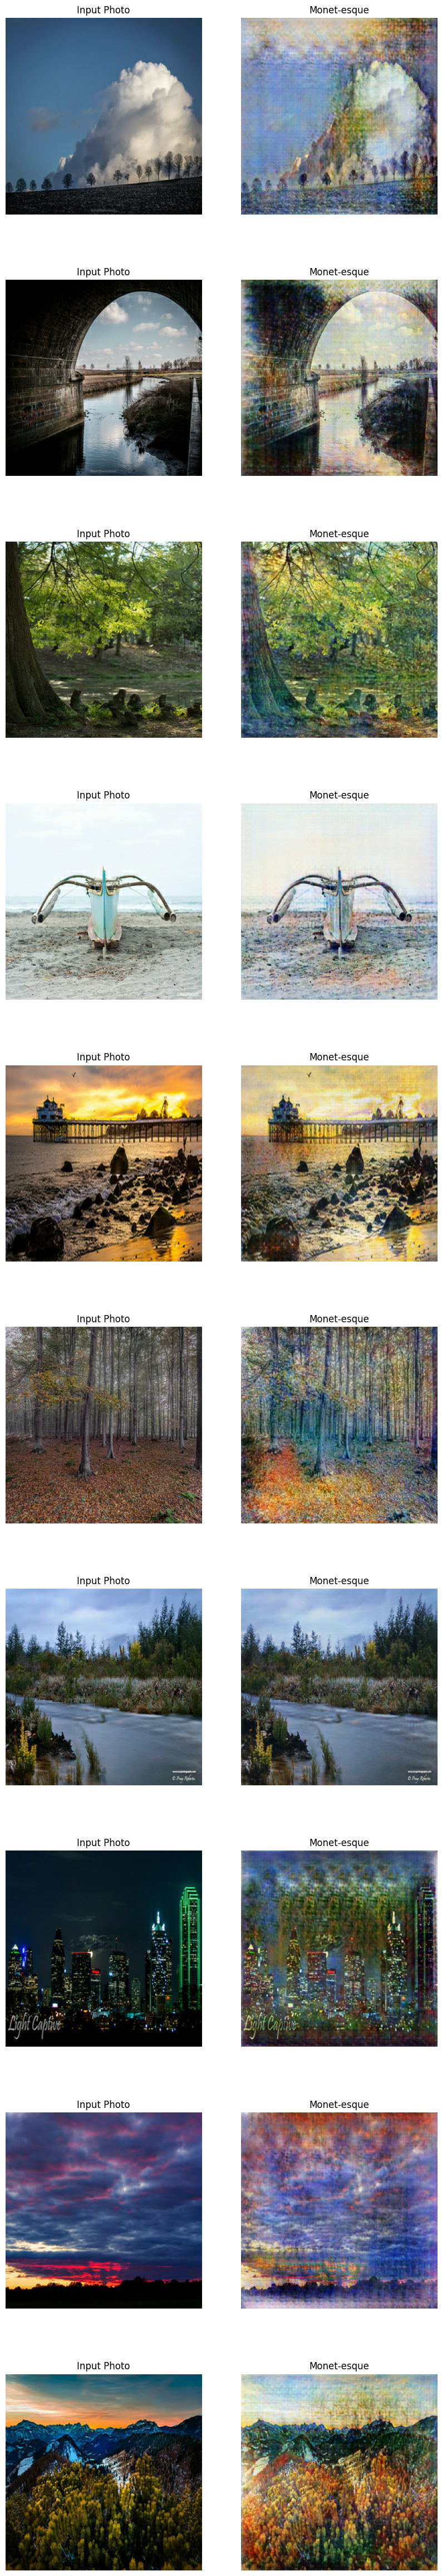

In [13]:
_, ax = plt.subplots(10, 2, figsize=(10, 60))
for i, img in enumerate(photo_ds.take(10)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Takeaways and Future Work

The CycleGAN model demonstrates strong initial learning, with generator and discriminator losses improving rapidly in the early epochs, indicating that the adversarial framework is functioning as intended. Over time, the losses stabilize, suggesting that the model has reached a point of equilibrium where both the generator and discriminator are effectively learning from one another. The absence of dramatic spikes or collapses in the losses is a positive sign of training stability and balance. However, the plateau in generator performance after around 40 epochs implies that the current setup may be reaching its capacity, with diminishing returns despite continued training.

Looking ahead, there are several avenues worth exploring to push the model’s performance further. Introducing a learning rate decay schedule—particularly after the model reaches the plateau phase—could help fine-tune the generator and improve output quality. Adjusting the cycle-consistency loss weight may also provide the generator with more stylistic flexibility, especially if overly strict reconstruction constraints are limiting its creative range. Adding architectural enhancements like residual blocks or attention mechanisms in the generator could improve the model’s capacity to capture complex artistic features. Lastly, integrating perceptual loss or conducting visual evaluations of generated outputs across epochs would offer more insight into the qualitative performance of the model. These adjustments could help the CycleGAN move beyond its current plateau and generate even more convincing and stylistically rich Monet-style images.

## Generate Images for Submission

In [14]:
import shutil
import os
from PIL import Image

try:
    os.mkdir('/kaggle/tmp')
except:
    pass

for i, img in enumerate(photo_ds.take(10000)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    image = Image.fromarray(prediction)
    image .save('../tmp/{:0=6}.jpg'.format(i))

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/tmp")

'/kaggle/working/images.zip'